<a href="https://colab.research.google.com/github/shishir-sh26/port/blob/main/gru%2Bcnn%2Cdrrpcnn%2Cgru%2Ccrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
import os

# Source (Google Drive)
source_dir = "/content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc"
# Destination (Colab local)
local_dir = "/content/MFCC_local"

if not os.path.exists(local_dir):
    shutil.copytree(source_dir, local_dir)

print(f"✅ MFCC files copied to local storage: {local_dir}")


✅ MFCC files copied to local storage: /content/MFCC_local


In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ---------------- CONFIG ----------------
BASE_DIR = "/content/MFCC_local"   # Local MFCC storage
TARGET_SHAPE = (40, 500)          # Example: 40 MFCC coefficients, 500 time frames
BATCH_SIZE = 64
EPOCHS = 10
PATIENCE = 5
RANDOM_SEED = 42

# GPU + mixed precision
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("⚡ Mixed precision enabled.\n")
except:
    print("Mixed precision not enabled.\n")


⚡ Mixed precision enabled.



In [ ]:
def fix_shape(array, target_shape=TARGET_SHAPE):
    out = np.zeros(target_shape, dtype=np.float32)
    min_mel = min(array.shape[0], target_shape[0])
    min_time = min(array.shape[1], target_shape[1])
    out[:min_mel, :min_time] = array[:min_mel, :min_time]
    return out


In [ ]:
# Collect files and labels
all_files = []
all_labels = []
classes = sorted(os.listdir(BASE_DIR))

for idx, cls in enumerate(classes):
    cls_files = glob(os.path.join(BASE_DIR, cls, "*.npy"))
    all_files.extend(cls_files)
    all_labels.extend([idx] * len(cls_files))

# Train/test split (80-20)
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, train_size=0.8, random_state=RANDOM_SEED, stratify=all_labels
)


In [ ]:
def make_dataset(file_paths, file_labels, batch_size=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

    def load_npy(file_path, label):
        array = tf.numpy_function(np.load, [file_path], tf.float32)
        array = tf.reshape(array, (*TARGET_SHAPE, 1))  # Add channel: (n_mfcc, time, 1)
        label_onehot = tf.one_hot(label, depth=len(classes))
        return array, label_onehot

    ds = ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, train_labels, training=True)
test_ds  = make_dataset(test_files, test_labels, training=False)

print("✅ GPU-ready datasets created!")


✅ GPU-ready datasets created!


In [ ]:
from tensorflow.keras import layers, models, callbacks

input_shape = (*TARGET_SHAPE, 1)
num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Reshape((-1, 64)),  # Flatten time dimension for GRU
    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax', dtype='float32')  # Keep output float32
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 500, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 250, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 250, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,893 (398.02 KB)

 Trainable params: 101,893 (398.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models

input_shape = (*TARGET_SHAPE, 1)
num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Flatten height dimension but keep time as sequence
    layers.Permute((2,1,3)),  # swap axes: (n_mels, time, channels) → (time, n_mels, channels)
    layers.Reshape((TARGET_SHAPE[1]//4, (TARGET_SHAPE[0]//4)*64)),  # after 2 poolings of (2,2)

    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])


In [ ]:
from tensorflow.keras import optimizers, losses

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/AvianWeatherNet/GRU_CNN_best.h5',
    monitor='val_loss',
    save_best_only=True
)


In [ ]:
def make_dataset(file_paths, file_labels, training=True, batch_size=64):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

    def load_npy(file_path, label):
        arr = tf.numpy_function(np.load, [file_path], tf.float32)
        arr = tf.reshape(arr, (13, 500, 1))  # MFCC shape
        label = tf.cast(label, tf.int32)     # 👈 cast to int
        return arr, tf.one_hot(label, depth=len(classes))

    ds = ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
def make_dataset(file_paths, file_labels, training=True, batch_size=64):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

    def load_npy(file_path, label):
        arr = tf.numpy_function(np.load, [file_path], tf.float32)
        arr = tf.reshape(arr, (13, 500, 1))  # MFCC shape
        label = tf.cast(label, tf.int32)     # <-- Cast float labels to int
        return arr, tf.one_hot(label, depth=len(classes))

    ds = ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
val_ds = make_dataset(val_files, val_labels, training=False)
train_ds = make_dataset(train_files, train_labels, training=True)
test_ds = make_dataset(test_files, test_labels, training=False)


In [ ]:
import numpy as np
import tensorflow as tf
from glob import glob
import os
from sklearn.model_selection import train_test_split

# ---------------- CONFIG ----------------
BASE_DIR = "/content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc"
TARGET_SHAPE = (13, 500)  # (n_mfcc, time_frames)
BATCH_SIZE = 64
RANDOM_SEED = 42

# ---------------- CLASSES ----------------
classes = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])
class_map = {c:i for i,c in enumerate(classes)}

# ---------------- FILES & LABELS ----------------
all_files, all_labels = [], []
for c in classes:
    cfiles = glob(os.path.join(BASE_DIR, c, "*.npy"))
    all_files.extend(cfiles)
    all_labels.extend([class_map[c]] * len(cfiles))

# ---------------- TRAIN/VAL/TEST SPLIT ----------------
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.20, random_state=RANDOM_SEED, shuffle=True
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.125, random_state=RANDOM_SEED, shuffle=True
)
# This ensures 80% train, 10% val, 10% test roughly

# ---------------- DATASET FUNCTION ----------------
def make_dataset(file_paths, file_labels, training=True, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

    def load_npy(file_path, label):
        arr = tf.numpy_function(np.load, [file_path], tf.float32)
        arr = tf.reshape(arr, (*TARGET_SHAPE, 1))  # (n_mfcc, time, 1)
        label = tf.cast(label, tf.int32)           # <-- important fix
        return arr, tf.one_hot(label, depth=len(classes))

    ds = ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

# ---------------- CREATE DATASETS ----------------
train_ds = make_dataset(train_files, train_labels, training=True)
val_ds   = make_dataset(val_files, val_labels, training=False)
test_ds  = make_dataset(test_files, test_labels, training=False)

print("✅ Datasets ready!")
print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")


✅ Datasets ready!
Train batches: 656, Val batches: 93, Test batches: 187


In [ ]:
from tensorflow.keras import layers, models

input_shape = (*TARGET_SHAPE, 1)  # (13, 500, 1)
num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=input_shape),

    # 2D CNN layers
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Flatten height dimension but keep time as sequence for GRU
    layers.Permute((2,1,3)),  # (n_mfcc, time, channels) → (time, n_mfcc, channels)
    layers.Reshape((TARGET_SHAPE[1]//4, (TARGET_SHAPE[0]//4)*64)),  # after 2 poolings

    # GRU
    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 13, 500, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 250, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 250, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 125, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 125, 3, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 125, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,045 (590.02 KB)

 Trainable params: 151,045 (590.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers, losses

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras import callbacks
CKPT_PATH = "/content/drive/MyDrive/AvianWeatherNet/GRU_CNN_checkpoint.h5"

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
checkpoint = callbacks.ModelCheckpoint(
    CKPT_PATH, monitor='val_loss', save_best_only=True
)


In [ ]:
print("Example MFCC shape:", train_ds.take(1))


Example MFCC shape: <_TakeDataset element_spec=(TensorSpec(shape=(64, 13, 500, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 5), dtype=tf.float32, name=None))>


In [ ]:
layers.Reshape((TARGET_SHAPE[1]//4, (TARGET_SHAPE[0]//4)*64))


<Reshape name=reshape_3, built=False>

In [ ]:
def compute_gru_input_shape(input_shape):
    n_mfcc, time_frames, channels = input_shape
    # Two MaxPooling2D layers with pool_size=2 reduce each dim by //2 twice
    new_mfcc = n_mfcc // 4
    new_time = time_frames // 4
    new_channels = 64  # last Conv2D filters
    return (new_time, new_mfcc*new_channels)

gru_input_shape = compute_gru_input_shape(TARGET_SHAPE + (1,))
print("GRU input shape:", gru_input_shape)


GRU input shape: (125, 192)


In [ ]:
layers.Reshape(gru_input_shape),


(<Reshape name=reshape_4, built=False>,)

In [ ]:
import numpy as np
import os
from glob import glob
from tqdm import tqdm

TARGET_SHAPE = (13, 500)  # (n_mfcc, time_frames)
BASE_DIR = "/content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc"

def fix_mfcc(arr, target_shape=TARGET_SHAPE):
    n_mfcc, time = arr.shape
    out = np.zeros(target_shape, dtype=np.float32)
    min_mfcc = min(n_mfcc, target_shape[0])
    min_time = min(time, target_shape[1])
    out[:min_mfcc, :min_time] = arr[:min_mfcc, :min_time]
    return out

all_files = glob(os.path.join(BASE_DIR, "*", "*.npy"))
print(f"🔎 Processing {len(all_files)} files...")

for file in tqdm(all_files, desc="Fixing MFCCs"):
    arr = np.load(file)
    if arr.shape != TARGET_SHAPE:
        arr_fixed = fix_mfcc(arr)
        np.save(file, arr_fixed)

print("✅ All MFCCs are now padded/truncated to", TARGET_SHAPE)


🔎 Processing 60030 files...


Fixing MFCCs: 100%|██████████| 60030/60030 [12:13<00:00, 81.82it/s]

✅ All MFCCs are now padded/truncated to (13, 500)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from glob import glob
import numpy as np

BASE_DIR = "/content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc"
TARGET_SHAPE = (13, 500)
BATCH_SIZE = 64
RANDOM_SEED = 42

# 1️⃣ Collect all files and labels
classes = sorted(os.listdir(BASE_DIR))
all_files, all_labels = [], []

for idx, cls in enumerate(classes):
    cls_files = glob(os.path.join(BASE_DIR, cls, "*.npy"))
    all_files.extend(cls_files)
    all_labels.extend([idx] * len(cls_files))

# 2️⃣ Train/Test split (80/20)
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=all_labels
)

# 3️⃣ Optional: further split test into val/test if you want a validation set
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, random_state=RANDOM_SEED, stratify=test_labels
)

# 4️⃣ Create tf.data.Dataset
def make_dataset(files, labels, batch_size=BATCH_SIZE, shuffle=True):
    files_ds = tf.data.Dataset.from_tensor_slices((files, labels))

    def load_npy(file_path, label):
        array = tf.numpy_function(np.load, [file_path], tf.float32)
        array = tf.reshape(array, (*TARGET_SHAPE, 1))  # Add channel dimension
        return array, tf.one_hot(tf.cast(label, tf.int32), depth=len(classes))

    ds = files_ds.map(load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 5️⃣ Create datasets
train_ds = make_dataset(train_files, train_labels, shuffle=True)
val_ds   = make_dataset(val_files, val_labels, shuffle=False)
test_ds  = make_dataset(test_files, test_labels, shuffle=False)

print("✅ Datasets ready")
print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")


✅ Datasets ready
Train batches: 751, Val batches: 94, Test batches: 94


In [ ]:
from tensorflow.keras import layers, models, callbacks

# 1️⃣ Model config
input_shape = (*TARGET_SHAPE, 1)  # (13, 500, 1)
num_classes = len(classes)

# 2️⃣ Build CNN+GRU model
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Flatten frequency (height) dimension, keep time as sequence
    layers.Permute((2,1,3)),  # (time, n_mels, channels)
    layers.Reshape((TARGET_SHAPE[1]//4, (TARGET_SHAPE[0]//4)*64)),  # adjust after 2 poolings

    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax', dtype='float32')  # force float32 for GPU
])

# 3️⃣ Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4️⃣ Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("gru_cnn_mfcc_best.h5", monitor='val_loss', save_best_only=True)

# 5️⃣ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 13, 500, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 250, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 250, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 125, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_2 (Permute)             │ (None, 125, 3, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 125, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,045 (590.02 KB)

 Trainable params: 151,045 (590.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3276 - loss: 1.4884

751/751 ━━━━━━━━━━━━━━━━━━━━ 363s 235ms/step - accuracy: 0.3276 - loss: 1.4884 - val_accuracy: 0.3978 - val_loss: 1.3586
Epoch 2/10
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4121 - loss: 1.3351

751/751 ━━━━━━━━━━━━━━━━━━━━ 171s 223ms/step - accuracy: 0.4122 - loss: 1.3350 - val_accuracy: 0.4829 - val_loss: 1.2192
Epoch 3/10
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4933 - loss: 1.1887

751/751 ━━━━━━━━━━━━━━━━━━━━ 199s 219ms/step - accuracy: 0.4934 - loss: 1.1885 - val_accuracy: 0.5194 - val_loss: 1.1338
Epoch 4/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5421 - loss: 1.0808

751/751 ━━━━━━━━━━━━━━━━━━━━ 171s 223ms/step - accuracy: 0.5421 - loss: 1.0808 - val_accuracy: 0.5770 - val_loss: 1.0087
Epoch 5/10
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5813 - loss: 0.9890

751/751 ━━━━━━━━━━━━━━━━━━━━ 173s 227ms/step - accuracy: 0.5813 - loss: 0.9889 - val_accuracy: 0.5945 - val_loss: 0.9635
Epoch 6/10
748/751 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6077 - loss: 0.9183

751/751 ━━━━━━━━━━━━━━━━━━━━ 173s 226ms/step - accuracy: 0.6078 - loss: 0.9182 - val_accuracy: 0.6250 - val_loss: 0.8885
Epoch 7/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6319 - loss: 0.8666

751/751 ━━━━━━━━━━━━━━━━━━━━ 199s 222ms/step - accuracy: 0.6319 - loss: 0.8665 - val_accuracy: 0.6334 - val_loss: 0.8673
Epoch 8/10
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6567 - loss: 0.8140

751/751 ━━━━━━━━━━━━━━━━━━━━ 172s 225ms/step - accuracy: 0.6568 - loss: 0.8140 - val_accuracy: 0.6588 - val_loss: 0.8059
Epoch 9/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6736 - loss: 0.7708

751/751 ━━━━━━━━━━━━━━━━━━━━ 204s 229ms/step - accuracy: 0.6736 - loss: 0.7708 - val_accuracy: 0.6753 - val_loss: 0.7899
Epoch 10/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6853 - loss: 0.7362

751/751 ━━━━━━━━━━━━━━━━━━━━ 198s 222ms/step - accuracy: 0.6853 - loss: 0.7361 - val_accuracy: 0.6733 - val_loss: 0.7819


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.6688 - loss: 0.7899
✅ Test Accuracy: 0.6652
✅ Test Loss: 0.7880


In [ ]:
model.save("gru_cnn_mfcc_best.keras")


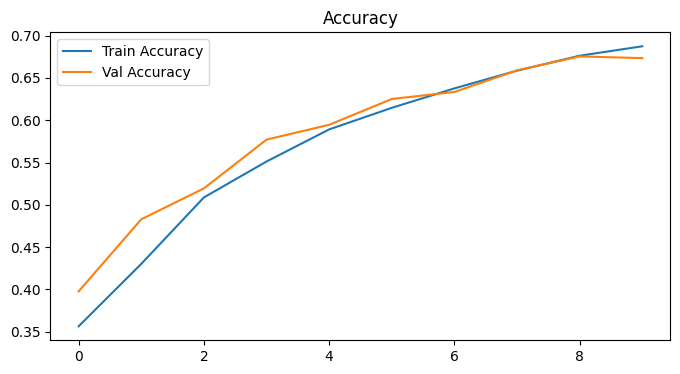

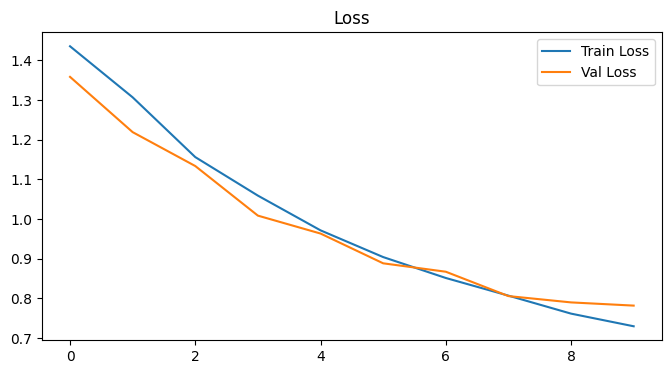

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━

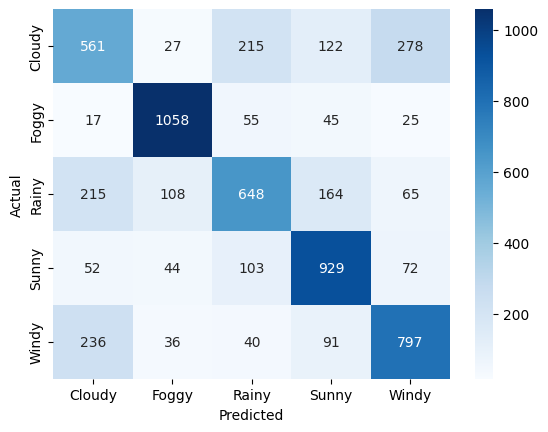

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for X, y in test_ds:
    preds = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━

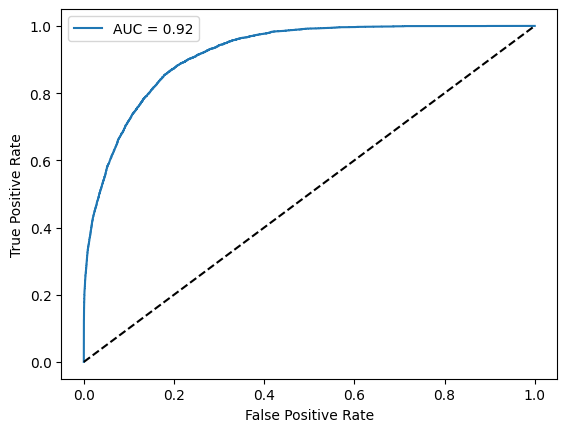

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(classes)))
y_pred_prob = np.array([p for X, _ in test_ds for p in model.predict(X)])

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


gru

In [ ]:
# Get input shape from dataset (removing the last channel dimension)
for X_batch, _ in train_ds.take(1):
    X_batch = tf.squeeze(X_batch, axis=-1)  # remove channel dim
    input_shape = X_batch.shape[1:]
print("📏 Input shape after squeeze:", input_shape)

# Squeeze channel dimension in datasets
train_ds_gru = train_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
val_ds_gru = val_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
test_ds_gru = test_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))

# Number of classes
num_classes = len(classes)

# Build GRU model
gru_model = tf.keras.Sequential([
    layers.Input(shape=input_shape),  # (time, features)
    layers.GRU(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.GRU(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
gru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
gru_history = gru_model.fit(
    train_ds_gru,
    validation_data=val_ds_gru,
    epochs=10
)

# Evaluate
test_loss, test_acc = gru_model.evaluate(test_ds_gru)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Save
gru_model.save("gru_mfcc.keras")


📏 Input shape after squeeze: (13, 500)
Epoch 1/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 177s 225ms/step - accuracy: 0.2313 - loss: 1.6208 - val_accuracy: 0.2574 - val_loss: 1.5701
Epoch 2/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 198s 224ms/step - accuracy: 0.2615 - loss: 1.5639 - val_accuracy: 0.2855 - val_loss: 1.5446
Epoch 3/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.2796 - loss: 1.5391 - val_accuracy: 0.2987 - val_loss: 1.5223
Epoch 4/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 195s 215ms/step - accuracy: 0.2937 - loss: 1.5212 - val_accuracy: 0.2970 - val_loss: 1.5078
Epoch 5/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 203s 217ms/step - accuracy: 0.3051 - loss: 1.5040 - val_accuracy: 0.3107 - val_loss: 1.4907
Epoch 6/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 205s 221ms/step - accuracy: 0.3171 - loss: 1.4923 - val_accuracy: 0.3285 - val_loss: 1.4763
Epoch 7/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 198s 215ms/step - accuracy: 0.3217 - loss: 1.4801 - val_accuracy: 0.3372 - val_loss: 1.4712
Epoch 8/10
751/751 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Save model
gru_model.save("gru_model.h5")

# Save training history
import pickle
with open("gru_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


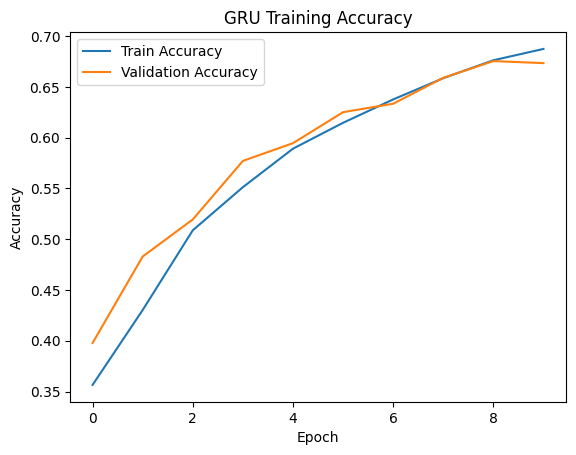

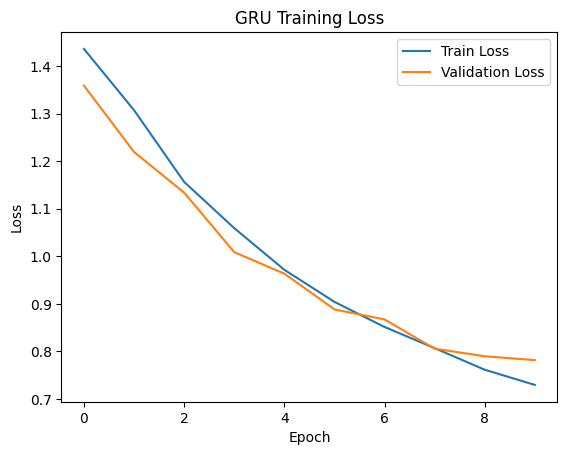

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('GRU Training Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training Loss')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━

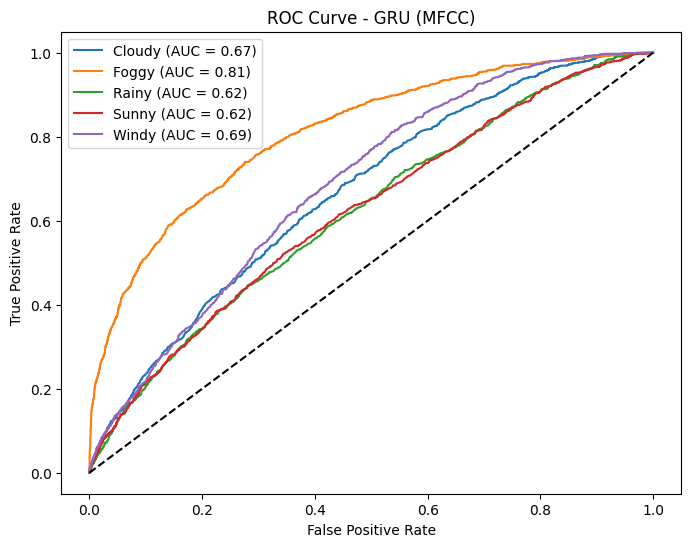

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Collect true labels & predicted probabilities
y_true = []
y_pred_all = []

for X, y in test_ds:  # your MFCC test dataset
    preds = gru_model.predict(X)
    y_true.extend(np.argmax(y, axis=1))  # actual class indices
    y_pred_all.extend(preds)  # predicted probabilities

y_true = np.array(y_true)
y_pred_all = np.array(y_pred_all)

# Binarize the true labels for multi-class ROC
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GRU (MFCC)")
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you already have:
# train_ds_mfcc, test_ds_mfcc, classes

# Input shape (MFCC features)
input_shape = (13, 500, 1)  # (n_mfcc, timesteps, channels)

# Build Deep CNN model
deep_cnn_model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(len(classes), activation='softmax')
])

# Compile model
deep_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deep_cnn_model.summary()

# Train model
history_deep_cnn = deep_cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

# Evaluate model
test_loss, test_acc = deep_cnn_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 13, 500, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 13, 500, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 13, 500, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 13, 500, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 250, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 250, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 250, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 250, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 250, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 250, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 3, 125, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 3, 125, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 3, 125, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 3, 125, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 62, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 62, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     4,063,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,213,637 (19.89 MB)

 Trainable params: 5,211,333 (19.88 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 221s 269ms/step - accuracy: 0.3060 - loss: 1.9512 - val_accuracy: 0.2992 - val_loss: 2.4751
Epoch 2/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 167s 218ms/step - accuracy: 0.4449 - loss: 1.4441 - val_accuracy: 0.4929 - val_loss: 1.2865
Epoch 3/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 167s 218ms/step - accuracy: 0.4983 - loss: 1.2823 - val_accuracy: 0.5286 - val_loss: 1.2061
Epoch 4/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 198s 212ms/step - accuracy: 0.5444 - loss: 1.1470 - val_accuracy: 0.5867 - val_loss: 1.0221
Epoch 5/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 165s 216ms/step - accuracy: 0.5840 - loss: 1.0418 - val_accuracy: 0.6314 - val_loss: 0.9062
Epoch 6/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 164s 214ms/step - accuracy: 0.6137 - loss: 0.9534 - val_accuracy: 0.6292 - val_loss: 1.0785
Epoch 7/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 163s 213ms/step - accuracy: 0.6427 - loss: 0.8734 - val_accuracy: 0.6435 - val_loss: 0.8876
Epoch 8/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 202s 214ms/step - accuracy: 0.6690 -

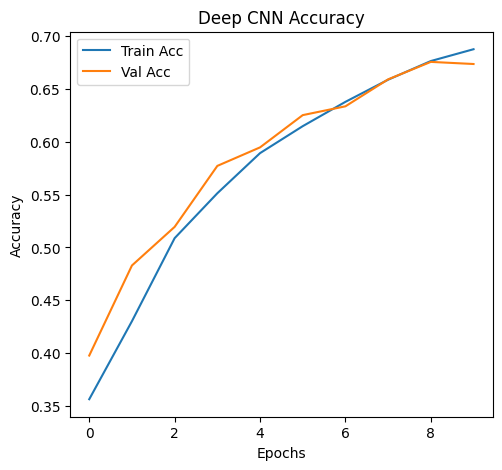

In [ ]:
# 3️⃣ Accuracy & Loss Curves
# =============================
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Deep CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

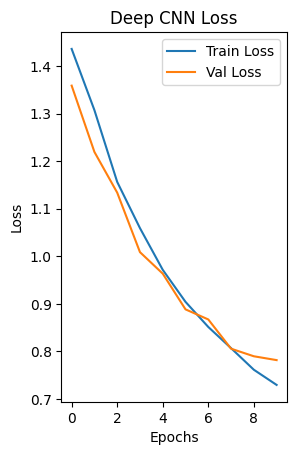

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 4️⃣ Evaluation & Predictions
# =============================
y_true = []
y_pred_probs = []

for x_batch, y_batch in test_ds:
    preds = deep_cnn_model.predict(x_batch)
    y_pred_probs.extend(preds)
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━

In [ ]:
# =============================
# 5️⃣ Confusion Matrix
# =============================
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Deep CNN')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━

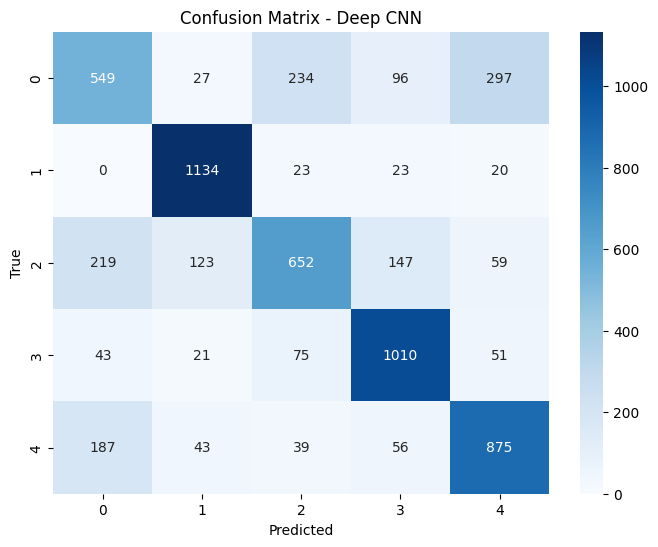

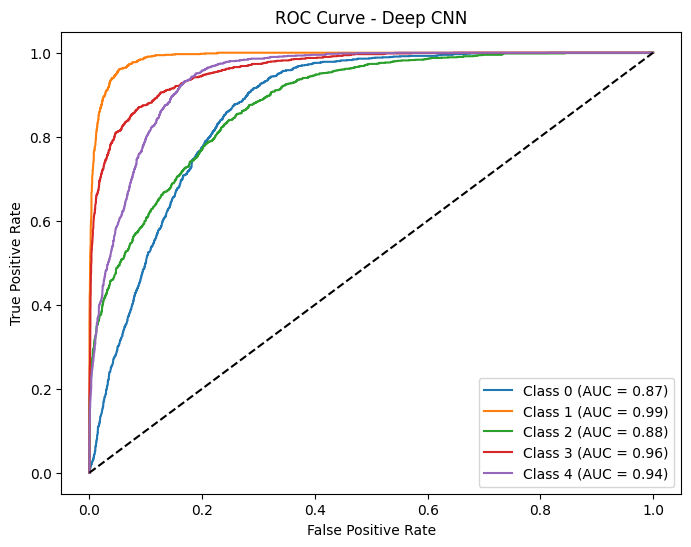

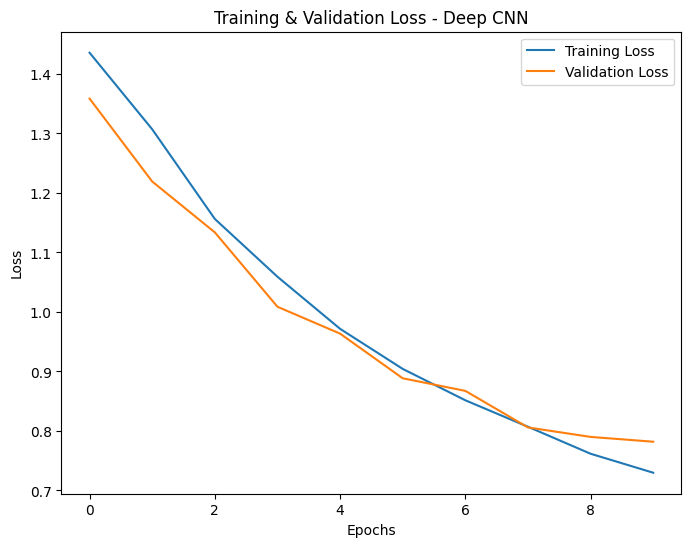

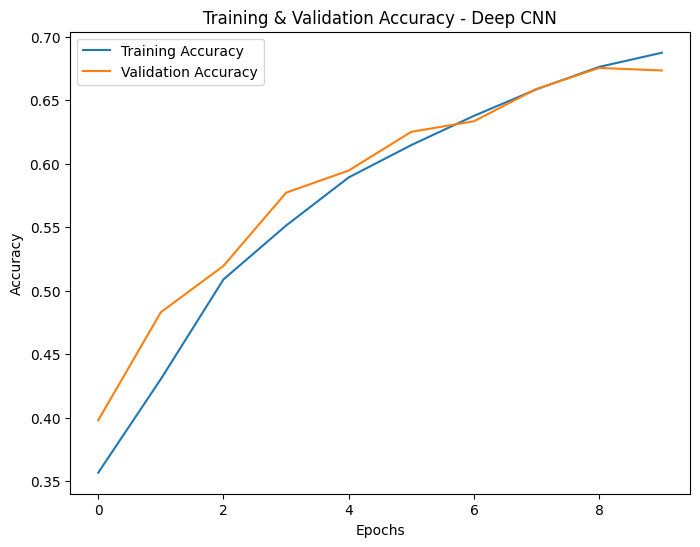

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ----- Predictions -----
y_true = []
y_pred_classes = []
y_pred_probs = []

for x_batch, y_batch in test_ds:  # MFCC test dataset
    preds = deep_cnn_model.predict(x_batch)
    y_pred_probs.extend(preds)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1))

y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.array(y_pred_classes)
y_true = np.array(y_true)

# ----- Classification Report -----
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Deep CNN")
plt.show()

# ----- ROC Curve & AUC -----
n_classes = y_pred_probs.shape[1]
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Deep CNN")
plt.legend()
plt.show()

# ----- Training Curves -----
# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss - Deep CNN")
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy - Deep CNN")
plt.legend()
plt.show()


In [ ]:
# Evaluate the Deep CNN model on the test set
test_loss, test_accuracy = deep_cnn_model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.7114 - loss: 0.6892
✅ Final Test Accuracy: 70.30%
✅ Final Test Loss: 0.6925


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Create save directory
# ------------------------------
save_dir = "/content/drive/MyDrive/AvianWeatherNet/srinivas/deep_CNN"
os.makedirs(save_dir, exist_ok=True)

# ------------------------------
# Save model
# ------------------------------
deep_cnn_model.save(os.path.join(save_dir, "deep_cnn_model.h5"))
print(f"✅ Model saved at: {os.path.join(save_dir, 'deep_cnn_model.h5')}")

# ------------------------------
# Plot & save training curves
# ------------------------------
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "training_curves.png"))
plt.close()
print(f"✅ Training curves saved at: {os.path.join(save_dir, 'training_curves.png')}")

# ------------------------------
# Confusion Matrix & Classification Report
# ------------------------------
y_true = []
y_pred_classes = []
y_pred_probs = []

for X_batch, y_batch in test_ds:
    preds = deep_cnn_model.predict(X_batch)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred_classes.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Deep CNN (MFCC)")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.close()
print(f"✅ Confusion matrix saved at: {os.path.join(save_dir, 'confusion_matrix.png')}")

# Classification report
report = classification_report(y_true, y_pred_classes)
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)
print(f"✅ Classification report saved at: {os.path.join(save_dir, 'classification_report.txt')}")


✅ Model saved at: /content/drive/MyDrive/AvianWeatherNet/srinivas/deep_CNN/deep_cnn_model.h5
✅ Training curves saved at: /content/drive/MyDrive/AvianWeatherNet/srinivas/deep_CNN/training_curves.png
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the directory to save artifacts in your Google Drive
save_dir = "/content/drive/MyDrive/AvianWeatherNet/deep_CNN_artifacts"
os.makedirs(save_dir, exist_ok=True)
print(f"Saving artifacts to: {save_dir}")

# 1. Save the Deep CNN model
model_save_path = os.path.join(save_dir, "deep_cnn_model.keras") # Use .keras format
deep_cnn_model.save(model_save_path)
print(f"✅ Deep CNN model saved at: {model_save_path}")

# 2. Save training history plots (Accuracy and Loss)
if 'history_deep_cnn' in locals(): # Check if history_deep_cnn exists
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_deep_cnn.history['accuracy'], label='Train Acc')
    plt.plot(history_deep_cnn.history['val_accuracy'], label='Val Acc')
    plt.title('Deep CNN Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_deep_cnn.history['loss'], label='Train Loss')
    plt.plot(history_deep_cnn.history['val_loss'], label='Val Loss')
    plt.title('Deep CNN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    training_curves_path = os.path.join(save_dir, "deep_cnn_training_curves.png")
    plt.savefig(training_curves_path)
    plt.close()
    print(f"✅ Training curves saved at: {training_curves_path}")
else:
    print("⚠️ Training history (history_deep_cnn) not found. Skipping saving training curves.")


# Re-calculate predictions and true labels for evaluation artifacts if necessary
# This block ensures we have the necessary data if the previous evaluation cells were not run right before this.
y_true_eval = []
y_pred_probs_eval = []

# Assuming test_ds is available from previous cells
if 'test_ds' in locals():
    print("Generating evaluation metrics...")
    for x_batch, y_batch in test_ds:
        preds = deep_cnn_model.predict(x_batch)
        y_pred_probs_eval.extend(preds)
        y_true_eval.extend(y_batch.numpy())

    y_true_eval = np.array(y_true_eval)
    y_pred_probs_eval = np.array(y_pred_probs_eval)
    y_pred_classes_eval = np.argmax(y_pred_probs_eval, axis=1)
    y_true_classes_eval = np.argmax(y_true_eval, axis=1)

    # 3. Save Classification Report
    # Assuming 'classes' is defined and contains the class names
    if 'classes' in locals():
        report = classification_report(y_true_classes_eval, y_pred_classes_eval, target_names=classes)
        classification_report_path = os.path.join(save_dir, "deep_cnn_classification_report.txt")
        with open(classification_report_path, "w") as f:
            f.write(report)
        print(f"✅ Classification report saved at: {classification_report_path}")
    else:
        print("⚠️ 'classes' variable not found. Skipping saving classification report.")


    # 4. Save Confusion Matrix plot
    cm = confusion_matrix(y_true_classes_eval, y_pred_classes_eval)
    plt.figure(figsize=(8, 6))
    # Assuming 'classes' is defined for xticklabels and yticklabels
    if 'classes' in locals():
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
    else:
         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # Save without class names if not available

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Deep CNN')
    confusion_matrix_path = os.path.join(save_dir, "deep_cnn_confusion_matrix.png")
    plt.savefig(confusion_matrix_path)
    plt.close()
    print(f"✅ Confusion matrix plot saved at: {confusion_matrix_path}")

    # 5. Save ROC Curve plot
    n_classes = y_pred_probs_eval.shape[1]
    y_test_bin = label_binarize(y_true_classes_eval, classes=list(range(n_classes)))

    plt.figure(figsize=(8, 6))
    if 'classes' in locals():
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs_eval[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")
    else:
         for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs_eval[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})") # Save with generic class names

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Deep CNN")
    plt.legend()
    roc_curve_path = os.path.join(save_dir, "deep_cnn_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"✅ ROC curve plot saved at: {roc_curve_path}")

else:
    print("⚠️ 'test_ds' variable not found. Skipping saving evaluation artifacts.")

Saving artifacts to: /content/drive/MyDrive/AvianWeatherNet/deep_CNN_artifacts
✅ Deep CNN model saved at: /content/drive/MyDrive/AvianWeatherNet/deep_CNN_artifacts/deep_cnn_model.keras
✅ Training curves saved at: /content/drive/MyDrive/AvianWeatherNet/deep_CNN_artifacts/deep_cnn_training_curves.png
Generating evaluation metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━

Saving GRU artifacts to: /content/drive/MyDrive/AvianWeatherNet/gru_artifacts
✅ GRU model saved at: /content/drive/MyDrive/AvianWeatherNet/gru_artifacts/gru_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 16 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ GRU model loaded successfully for evaluation.
✅ GRU training curves saved at: /content/drive/MyDrive/AvianWeatherNet/gru_artifacts/gru_training_curves.png
Generating GRU evaluation metrics...
✅ GRU classification report saved at: /content/drive/MyDrive/AvianWeatherNet/gru_artifacts/gru_classification_report.txt
✅ GRU confusion matrix plot saved at: /content/drive/MyDrive/AvianWeatherNet/gru_artifacts/gru_confusion_matrix.png


KeyboardInterrupt: 

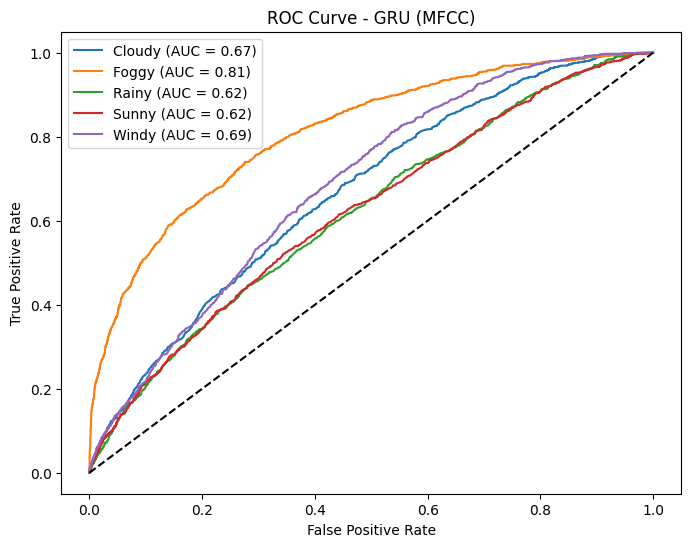

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import drive
import tensorflow as tf # Import tensorflow

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the directory to save artifacts in your Google Drive
save_dir_gru = "/content/drive/MyDrive/AvianWeatherNet/gru_artifacts"
os.makedirs(save_dir_gru, exist_ok=True)
print(f"Saving GRU artifacts to: {save_dir_gru}")

# 1. Save the GRU model
# Assuming your GRU model is named 'gru_model'
model_save_path_gru = os.path.join(save_dir_gru, "gru_model.keras") # Use .keras format
if 'gru_model' in locals():
    try:
        gru_model.save(model_save_path_gru)
        print(f"✅ GRU model saved at: {model_save_path_gru}")

        # Load the model back to ensure a clean state for prediction
        loaded_gru_model = tf.keras.models.load_model(model_save_path_gru)
        print("✅ GRU model loaded successfully for evaluation.")
        model_for_prediction = loaded_gru_model # Use the loaded model
    except Exception as e:
        print(f"❌ Error saving or loading GRU model: {e}")
        model_for_prediction = gru_model # Fallback to the original model if saving/loading fails
else:
    print("⚠️ GRU model ('gru_model') not found. Skipping model saving.")
    model_for_prediction = None


# 2. Save training history plots (Accuracy and Loss)
# Assuming your GRU training history is named 'gru_history'
if 'gru_history' in locals():
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(gru_history.history['accuracy'], label='Train Acc')
    plt.plot(gru_history.history['val_accuracy'], label='Val Acc')
    plt.title('GRU Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(gru_history.history['loss'], label='Train Loss')
    plt.plot(gru_history.history['val_loss'], label='Val Loss')
    plt.title('GRU Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    training_curves_path_gru = os.path.join(save_dir_gru, "gru_training_curves.png")
    plt.savefig(training_curves_path_gru)
    plt.close()
    print(f"✅ GRU training curves saved at: {training_curves_path_gru}")
else:
    print("⚠️ GRU training history ('gru_history') not found. Skipping saving training curves.")


# Generate predictions and true labels for evaluation artifacts
y_true_eval_gru = []
y_pred_probs_eval_gru = []

# Assuming test_ds_gru is available from previous cells and model_for_prediction exists
if 'test_ds_gru' in locals() and model_for_prediction is not None:
    print("Generating GRU evaluation metrics...")

    # Collect predictions and true labels by manually iterating and predicting batch by batch
    for x_batch, y_batch in test_ds_gru:
        # Perform forward pass manually
        # This assumes the model_for_prediction is a Sequential model and the last layer is softmax
        # If your model structure is different, this part might need adjustment
        preds = model_for_prediction(x_batch, training=False).numpy() # Use model call and get numpy output

        y_pred_probs_eval_gru.extend(preds)
        y_true_eval_gru.extend(y_batch.numpy())

    y_true_eval_gru = np.array(y_true_eval_gru)
    y_pred_probs_eval_gru = np.array(y_pred_probs_eval_gru)

    # Check if any predictions were made before proceeding with evaluation metrics
    if y_pred_probs_eval_gru.size > 0:
        y_pred_classes_eval_gru = np.argmax(y_pred_probs_eval_gru, axis=1)
        y_true_classes_eval_gru = np.argmax(y_true_eval_gru, axis=1)


        # 3. Save Classification Report
        # Assuming 'classes' is defined and contains the class names
        if 'classes' in locals():
            report_gru = classification_report(y_true_classes_eval_gru, y_pred_classes_eval_gru, target_names=classes)
            classification_report_path_gru = os.path.join(save_dir_gru, "gru_classification_report.txt")
            with open(classification_report_path_gru, "w") as f:
                    f.write(report_gru)
            print(f"✅ GRU classification report saved at: {classification_report_path_gru}")
        else:
            print("⚠️ 'classes' variable not found. Skipping saving GRU classification report.")


        # 4. Save Confusion Matrix plot
        cm_gru = confusion_matrix(y_true_classes_eval_gru, y_pred_classes_eval_gru)
        plt.figure(figsize=(8, 6))
        # Assuming 'classes' is defined for xticklabels and yticklabels
        if 'classes' in locals():
            sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
                        xticklabels=classes, yticklabels=classes)
        else:
             sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues') # Save without class names if not available

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix - GRU (MFCC)')
        confusion_matrix_path_gru = os.path.join(save_dir_gru, "gru_confusion_matrix.png")
        plt.savefig(confusion_matrix_path_gru)
        plt.close()
        print(f"✅ GRU confusion matrix plot saved at: {confusion_matrix_path_gru}")

        # 5. Save ROC Curve plot
        n_classes_gru = y_pred_probs_eval_gru.shape[1]
        y_test_bin_gru = label_binarize(y_true_classes_eval_gru, classes=list(range(n_classes_gru)))

        plt.figure(figsize=(8, 6))
        if 'classes' in locals():
            for i in range(n_classes_gru):
                fpr_gru, tpr_gru, _ = roc_curve(y_test_bin_gru[:, i], y_pred_probs_eval_gru[:, i])
                roc_auc_gru = auc(fpr_gru, tpr_gru)
                plt.plot(fpr_gru, tpr_gru, label=f"{classes[i]} (AUC = {roc_auc_gru:.2f})")
        else:
             for i in range(n_classes_gru):
                fpr_gru, tpr_gru, _ = roc_curve(y_test_bin_gru[:, i], y_pred_probs_eval_gru[:, i])
                roc_auc_gru = auc(fpr_gru, tpr_gru)
                plt.plot(fpr_gru, tpr_gru, label=f"Class {i} (AUC = {roc_auc_gru:.2f})") # Save with generic class names


        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - GRU (MFCC)")
        plt.legend()
        roc_curve_path_gru = os.path.join(save_dir_gru, "gru_roc_curve.png")
        plt.savefig(roc_curve_path_gru)
        plt.close()
        print(f"✅ GRU ROC curve plot saved at: {roc_curve_path_gru}")
    else:
         print("⚠️ No predictions were generated. Skipping saving GRU evaluation artifacts.")


else:
    print("⚠️ 'test_ds_gru' or 'gru_model' not found (or failed to load). Skipping saving GRU evaluation artifacts.")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import drive
import tensorflow as tf

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the directory to save artifacts in your Google Drive
save_dir_gru_cnn = "/content/drive/MyDrive/AvianWeatherNet/gru_cnn_artifacts"
os.makedirs(save_dir_gru_cnn, exist_ok=True)
print(f"Saving GRU+CNN artifacts to: {save_dir_gru_cnn}")

# 1. Save the GRU+CNN model
# Assuming your GRU+CNN model is named 'model'
model_save_path_gru_cnn = os.path.join(save_dir_gru_cnn, "gru_cnn_model.keras") # Use .keras format
if 'model' in locals():
    try:
        model.save(model_save_path_gru_cnn)
        print(f"✅ GRU+CNN model saved at: {model_save_path_gru_cnn}")

        # Load the model back for evaluation to ensure consistency
        loaded_gru_cnn_model = tf.keras.models.load_model(model_save_path_gru_cnn)
        print("✅ GRU+CNN model loaded successfully for evaluation.")
        model_for_prediction = loaded_gru_cnn_model
    except Exception as e:
        print(f"❌ Error saving or loading GRU+CNN model: {e}")
        model_for_prediction = model # Fallback to original if save/load fails
else:
    print("⚠️ GRU+CNN model ('model') not found. Skipping model saving and evaluation artifacts.")
    model_for_prediction = None


# 2. Save training history plots (Accuracy and Loss)
# Assuming your GRU+CNN training history is named 'history'
if 'history' in locals():
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('GRU+CNN Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('GRU+CNN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    training_curves_path_gru_cnn = os.path.join(save_dir_gru_cnn, "gru_cnn_training_curves.png")
    plt.savefig(training_curves_path_gru_cnn)
    plt.close()
    print(f"✅ GRU+CNN training curves saved at: {training_curves_path_gru_cnn}")
else:
    print("⚠️ GRU+CNN training history ('history') not found. Skipping saving training curves.")


# Generate predictions and true labels for evaluation artifacts
y_true_eval_gru_cnn = []
y_pred_probs_eval_gru_cnn = []

# Assuming test_ds is available from previous cells and model_for_prediction exists
if 'test_ds' in locals() and model_for_prediction is not None:
    print("Generating GRU+CNN evaluation metrics...")

    # Collect predictions and true labels batch by batch
    for x_batch, y_batch in test_ds: # Use the standard test dataset for GRU+CNN
        preds = model_for_prediction.predict(x_batch)
        y_pred_probs_eval_gru_cnn.extend(preds)
        y_true_eval_gru_cnn.extend(y_batch.numpy())

    y_true_eval_gru_cnn = np.array(y_true_eval_gru_cnn)
    y_pred_probs_eval_gru_cnn = np.array(y_pred_probs_eval_gru_cnn)

    # Check if any predictions were made before proceeding with evaluation metrics
    if y_pred_probs_eval_gru_cnn.size > 0:
        y_pred_classes_eval_gru_cnn = np.argmax(y_pred_probs_eval_gru_cnn, axis=1)
        y_true_classes_eval_gru_cnn = np.argmax(y_true_eval_gru_cnn, axis=1)


        # 3. Save Classification Report
        # Assuming 'classes' is defined and contains the class names
        if 'classes' in locals():
            report_gru_cnn = classification_report(y_true_classes_eval_gru_cnn, y_pred_classes_eval_gru_cnn, target_names=classes)
            classification_report_path_gru_cnn = os.path.join(save_dir_gru_cnn, "gru_cnn_classification_report.txt")
            with open(classification_report_path_gru_cnn, "w") as f:
                    f.write(report_gru_cnn)
            print(f"✅ GRU+CNN classification report saved at: {classification_report_path_gru_cnn}")
        else:
            print("⚠️ 'classes' variable not found. Skipping saving GRU+CNN classification report.")


        # 4. Save Confusion Matrix plot
        cm_gru_cnn = confusion_matrix(y_true_classes_eval_gru_cnn, y_pred_classes_eval_gru_cnn)
        plt.figure(figsize=(8, 6))
        # Assuming 'classes' is defined for xticklabels and yticklabels
        if 'classes' in locals():
            sns.heatmap(cm_gru_cnn, annot=True, fmt='d', cmap='Blues',
                        xticklabels=classes, yticklabels=classes)
        else:
             sns.heatmap(cm_gru_cnn, annot=True, fmt='d', cmap='Blues') # Save without class names if not available

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix - GRU+CNN (MFCC)')
        confusion_matrix_path_gru_cnn = os.path.join(save_dir_gru_cnn, "gru_cnn_confusion_matrix.png")
        plt.savefig(confusion_matrix_path_gru_cnn)
        plt.close()
        print(f"✅ GRU+CNN confusion matrix plot saved at: {confusion_matrix_path_gru_cnn}")

        # 5. Save ROC Curve plot
        n_classes_gru_cnn = y_pred_probs_eval_gru_cnn.shape[1]
        y_test_bin_gru_cnn = label_binarize(y_true_classes_eval_gru_cnn, classes=list(range(n_classes_gru_cnn)))

        plt.figure(figsize=(8, 6))
        if 'classes' in locals():
            for i in range(n_classes_gru_cnn):
                fpr_gru_cnn, tpr_gru_cnn, _ = roc_curve(y_test_bin_gru_cnn[:, i], y_pred_probs_eval_gru_cnn[:, i])
                roc_auc_gru_cnn = auc(fpr_gru_cnn, tpr_gru_cnn)
                plt.plot(fpr_gru_cnn, tpr_gru_cnn, label=f"{classes[i]} (AUC = {roc_auc_gru_cnn:.2f})")
        else:
             for i in range(n_classes_gru_cnn):
                fpr_gru_cnn, tpr_gru_cnn, _ = roc_curve(y_test_bin_gru_cnn[:, i], y_pred_probs_eval_gru_cnn[:, i])
                roc_auc_gru_cnn = auc(fpr_gru_cnn, tpr_gru_cnn)
                plt.plot(fpr_gru_cnn, tpr_gru_cnn, label=f"Class {i} (AUC = {roc_auc_gru_cnn:.2f})") # Save with generic class names


        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - GRU+CNN (MFCC)")
        plt.legend()
        roc_curve_path_gru_cnn = os.path.join(save_dir_gru_cnn, "gru_cnn_roc_curve.png")
        plt.savefig(roc_curve_path_gru_cnn)
        plt.close()
        print(f"✅ GRU+CNN ROC curve plot saved at: {roc_curve_path_gru_cnn}")
    else:
         print("⚠️ No predictions were generated. Skipping saving GRU+CNN evaluation artifacts.")


else:
    print("⚠️ 'test_ds' or 'model' not found (or failed to load). Skipping saving GRU+CNN evaluation artifacts.")

Saving GRU+CNN artifacts to: /content/drive/MyDrive/AvianWeatherNet/gru_cnn_artifacts
✅ GRU+CNN model saved at: /content/drive/MyDrive/AvianWeatherNet/gru_cnn_artifacts/gru_cnn_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 17 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ GRU+CNN model loaded successfully for evaluation.
✅ GRU+CNN training curves saved at: /content/drive/MyDrive/AvianWeatherNet/gru_cnn_artifacts/gru_cnn_training_curves.png
Generating GRU+CNN evaluation metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input shape for MFCC: (n_mfcc, timesteps, channels)
input_shape = (13, 500, 1)  # MFCC features

# Build CRNN model
crnn_model = models.Sequential([
    layers.Input(shape=input_shape),

    # --- Convolutional Feature Extractor ---
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # --- Flatten frequency axis, keep time axis ---
    layers.Reshape((input_shape[1] // 4, -1)),  # timesteps reduced by pooling

    # --- Recurrent Layers ---
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.GRU(64)),

    # --- Fully Connected ---
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(len(classes), activation='softmax')
])

# Compile
crnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

crnn_model.summary()

# Train
history_crnn = crnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

# Evaluate
test_loss, test_acc = crnn_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 13, 500, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 13, 500, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 250, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 6, 250, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 250, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 6, 250, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 3, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 125, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 125, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,333 (2.33 MB)

 Trainable params: 610,693 (2.33 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 178s 224ms/step - accuracy: 0.2537 - loss: 1.9951 - val_accuracy: 0.3963 - val_loss: 1.3815
Epoch 2/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 205s 227ms/step - accuracy: 0.3566 - loss: 1.5163 - val_accuracy: 0.4231 - val_loss: 1.3907
Epoch 3/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 196s 220ms/step - accuracy: 0.4140 - loss: 1.3880 - val_accuracy: 0.4573 - val_loss: 1.3219
Epoch 4/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 171s 224ms/step - accuracy: 0.4396 - loss: 1.3060 - val_accuracy: 0.4758 - val_loss: 1.3072
Epoch 5/5
751/751 ━━━━━━━━━━━━━━━━━━━━ 201s 223ms/step - accuracy: 0.4738 - loss: 1.2400 - val_accuracy: 0.5001 - val_loss: 1.2242
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.4893 - loss: 1.2568
✅ Test Accuracy: 0.5001


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 📁 Save folder
save_dir = "/content/drive/MyDrive/AvianWeatherNet/srinivas/CRNN"
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Plot Training & Validation Accuracy/Loss
plt.figure()
plt.plot(history_crnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CRNN - Accuracy")
plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
plt.close()

plt.figure()
plt.plot(history_crnn.history['loss'], label='Train Loss')
plt.plot(history_crnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("CRNN - Loss")
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.close()

# 2️⃣ Predictions for classification report & confusion matrix
y_true = []
y_pred_classes = []
y_pred_probs = []

for x_batch, y_batch in test_ds:
    preds = crnn_model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)
y_pred_probs = np.array(y_pred_probs)

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=classes)
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)

# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CRNN - Confusion Matrix")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.close()

# 4️⃣ ROC & AUC
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

plt.figure()
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CRNN - ROC Curve")
plt.legend()
plt.savefig(os.path.join(save_dir, "roc_curve.png"))
plt.close()

print(f"✅ All CRNN reports & graphs saved to: {save_dir}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━

In [ ]:
# 📁 Path to save CRNN model
model_save_path = "/content/drive/MyDrive/AvianWeatherNet/srinivas/CRNN/crnn_model.h5"

# Save the trained model
crnn_model.save(model_save_path)

print(f"✅ CRNN model saved at: {model_save_path}")


✅ CRNN model saved at: /content/drive/MyDrive/AvianWeatherNet/srinivas/CRNN/crnn_model.h5


In [ ]:
# Evaluate on test set
test_loss, test_acc = crnn_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.4893 - loss: 1.2568
✅ Test Accuracy: 0.5001
✅ Test Loss: 1.2242


In [ ]:
import numpy as np

# Get predictions
y_pred_probs = crnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)

# Map predictions to class names
predicted_labels = [classes[i] for i in y_pred]
true_labels = [classes[i] for i in y_true]

# Show first 10 predictions
for i in range(10):
    print(f"🎯 True: {true_labels[i]}  |  🔮 Predicted: {predicted_labels[i]}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step
🎯 True: Rainy  |  🔮 Predicted: Cloudy
🎯 True: Cloudy  |  🔮 Predicted: Cloudy
🎯 True: Rainy  |  🔮 Predicted: Rainy
🎯 True: Cloudy  |  🔮 Predicted: Rainy
🎯 True: Windy  |  🔮 Predicted: Rainy
🎯 True: Rainy  |  🔮 Predicted: Rainy
🎯 True: Rainy  |  🔮 Predicted: Foggy
🎯 True: Windy  |  🔮 Predicted: Windy
🎯 True: Rainy  |  🔮 Predicted: Cloudy
🎯 True: Cloudy  |  🔮 Predicted: Cloudy


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ====== Create save directory ======
save_dir = "/content/drive/MyDrive/AvianWeatherNet/srinivas/CRNN"
os.makedirs(save_dir, exist_ok=True)

# ====== Evaluate model ======
test_loss, test_acc = crnn_model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

# ====== Predictions ======
y_true = []
y_pred = []

for X, y in test_ds:
    preds = crnn_model.predict(X)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ====== Classification Report ======
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("\n📊 Classification Report:\n", report)

# Save report
with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(report)

# ====== Confusion Matrix ======
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("CRNN Confusion Matrix")
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.close()

# ====== Training Curves ======
plt.figure(figsize=(8, 5))
plt.plot(history_crnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CRNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
plt.close()

plt.figure(figsize=(8, 5))
plt.plot(history_crnn.history['loss'], label='Train Loss')
plt.plot(history_crnn.history['val_loss'], label='Validation Loss')
plt.title("CRNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.close()

# ====== Save Model ======
crnn_model.save(os.path.join(save_dir, "crnn_model.h5"))
print(f"💾 Model and results saved in: {save_dir}")

# ====== Sample Predictions ======
print("\n🎯 Sample Predictions:")
for i in range(10):
    print(f"🎯 True: {classes[y_true[i]]}  |  🔮 Predicted: {classes[y_pred[i]]}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.4893 - loss: 1.2568
✅ Test Accuracy: 0.5001
📉 Test Loss: 1.2242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━

💾 Model and results saved in: /content/drive/MyDrive/AvianWeatherNet/srinivas/CRNN

🎯 Sample Predictions:
🎯 True: Rainy  |  🔮 Predicted: Cloudy
🎯 True: Cloudy  |  🔮 Predicted: Cloudy
🎯 True: Rainy  |  🔮 Predicted: Rainy
🎯 True: Cloudy  |  🔮 Predicted: Rainy
🎯 True: Windy  |  🔮 Predicted: Rainy
🎯 True: Rainy  |  🔮 Predicted: Rainy
🎯 True: Rainy  |  🔮 Predicted: Foggy
🎯 True: Windy  |  🔮 Predicted: Windy
🎯 True: Rainy  |  🔮 Predicted: Cloudy
🎯 True: Cloudy  |  🔮 Predicted: Cloudy
